In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping

2025-06-11 16:51:56.539838: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 16:51:56.541116: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 16:51:56.550268: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 16:51:56.562153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 16:51:56.584866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Load pre-processed dataset

In [2]:
# Load full preprocessed dataset
path= "../raw_data/train_df_ml_clean.csv"
full_prepoc_df = pd.read_csv(path)

In [ ]:
# Load a fraction of the full preprocessed dataset to reduce computation load
sample_preproc_df = full_prepoc_df.sample(frac=0.1)
len(sample_preproc_df)

360000

In [ ]:
# Display head of sampled preprocessed dataset
sample_preproc_df.head()

,label,text,clean_text
1459873,0,Good idea poorly executed: The Delphi SkyFi3 i...,good idea poorly executed the delphi skyfi3 is...
3183647,1,"the sims 2, a great new game!: i think that th...",the sims a great new game i think that the sim...
1802979,0,Give me a break: Maybe this book could have be...,give me a break maybe this book could have bee...
102865,1,"Very good work, by a brilliant cricket writer:...",very good work by a brilliant cricket writer i...
1000720,0,Am I in another dimension?: I want my money ba...,am i in another dimension i want my money back...


In [ ]:
# Create X and y, convert into np arrays
X = sample_preproc_df['clean_text'].to_numpy()
y = sample_preproc_df['label'].to_numpy()

In [ ]:
# Split X and y into train and validation

val_size= 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=42
)

len(X_train), len(X_val)

In [ ]:
# Array with the length of every sentence
length_array = [len(seq) for seq in X_train.astype(str)]

# Plot histogram of length array to identify suitable max_length
plt.hist(length_array)

[776,
 261,
 261,
 464,
 482,
 836,
 362,
 643,
 139,
 193,
 260,
 745,
 126,
 185,
 197,
 732,
 529,
 271,
 717,
 374,
 122,
 404,
 105,
 288,
 496,
 405,
 437,
 581,
 229,
 377,
 450,
 644,
 122,
 612,
 920,
 414,
 206,
 574,
 844,
 196,
 362,
 522,
 582,
 895,
 217,
 868,
 337,
 216,
 517,
 441,
 618,
 252,
 218,
 378,
 213,
 376,
 126,
 527,
 659,
 206,
 154,
 165,
 368,
 192,
 138,
 560,
 156,
 670,
 933,
 725,
 899,
 609,
 416,
 168,
 533,
 344,
 147,
 297,
 301,
 611,
 539,
 235,
 175,
 160,
 296,
 356,
 398,
 479,
 827,
 358,
 146,
 937,
 855,
 219,
 465,
 174,
 609,
 402,
 197,
 517,
 103,
 143,
 324,
 690,
 246,
 287,
 241,
 786,
 511,
 587,
 358,
 223,
 468,
 568,
 191,
 925,
 803,
 288,
 607,
 728,
 325,
 565,
 186,
 579,
 469,
 291,
 167,
 369,
 139,
 208,
 487,
 165,
 538,
 473,
 197,
 441,
 453,
 863,
 134,
 188,
 222,
 285,
 897,
 136,
 262,
 747,
 679,
 317,
 130,
 326,
 290,
 373,
 196,
 580,
 369,
 306,
 711,
 492,
 565,
 920,
 418,
 573,
 310,
 660,
 102,
 773,
 222

# Tokenize every sentence

In [55]:
X_train_token = [text_to_word_sequence(_) for _ in X_train.astype(str)]
X_val_token = [text_to_word_sequence(_) for _ in X_val.astype(str)]

# Train Word2Vec on corpus of X_train_token

In [56]:
# Learn embedding representation of words in reviews
word2vec = Word2Vec(sentences=X_train_token, vector_size=50, min_count=5) #Reduced vector size from 100 to 50
# Store words and trained embeddings in wv
wv = word2vec.wv

In [ ]:
# Compute the distinct vocabulary values
len(wv.key_to_index.keys())

52374

# Generate Padded Embeddings for every sentence

## Definition of function that generates padded embeddings per batch of sentences

In [ ]:
import os
import pickle
import numpy as np

# Import joblib Parallel class for multithread processing
from joblib import Parallel, delayed

In [59]:
def process_sentence_batch_to_disk(wv_vectors, wv_vocab, vector_size, sentences_batch, batch_index, output_dir):
    """
    Processes a sentence batch and saves the result to disk using pickle.
    """
    batch_embeddings = []

    for sentence in sentences_batch:
        valid_words = [word for word in sentence if word in wv_vocab]
        if valid_words:
            embeddings = np.array([wv_vectors[word] for word in valid_words])
        else:
            embeddings = np.array([]).reshape(0, vector_size)

        batch_embeddings.append(embeddings)

    padded_embedding = pad_sequences(batch_embeddings, maxlen=400, padding='post', value=0, dtype='float32')

    # Save batch to disk
    file_path = os.path.join(output_dir, f'batch_{batch_index}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(padded_embedding, f)

    return file_path

In [60]:
def embedding_optimized_to_disk(wv, sentences, batch_size=10, n_jobs=-1, output_dir='embeddings_batches'):
    """
    Optimized embedding function that saves intermediate results to disk to avoid memory overload.
    """
    print(f"Processing {len(sentences)} sentences...")

    os.makedirs(output_dir, exist_ok=True)

    vocab = set(wv.key_to_index.keys())
    vector_size = wv.vector_size
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    print(f"Created {len(batches)} batches of ~{batch_size} sentences each")
    print(f"Using {n_jobs} parallel processes...")

    # Process and store results to disk in parallel
    result_files = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(
        delayed(process_sentence_batch_to_disk)(wv, vocab, vector_size, batch, idx, output_dir)
        for idx, batch in enumerate(batches)
    )

    print(f"Embeddings saved to disk at '{output_dir}'. Total: {len(result_files)} files.")
    return result_files

## Define train parameters

In [ ]:
train_batch_size = 50 # 50 sentences to be processed as a batch for train
train_len = 50000 # Limit of rows to process

In [ ]:
# Batch processing & storage of train padded embedding sentences
train_file_paths = embedding_optimized_to_disk(wv, X_train_token[:train_len], batch_size=train_batch_size, n_jobs=-1, output_dir='train_embeddings_batches')

Processing 50000 sentences...
Created 1000 batches of ~50 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
2025-06-11 15:24:09.164825: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different 2025-06-11 15:24:09.164828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 15:24:09.165028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 15:24:09.165141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

Embeddings saved to disk at 'train_embeddings_batches'. Total: 1000 files.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.4s finished


## Define val parameters

In [ ]:
val_batch_size = int(train_batch_size * val_size) # Number of val sentences per file
val_len = int(train_len * val_size) # Total number of val sentences

In [ ]:
# Batch processing & storage of val padded embedding sentences
val_file_paths = embedding_optimized_to_disk(wv, X_val_token[:val_len], batch_size=val_batch_size, n_jobs=-1, output_dir='val_embeddings_batches')

Processing 10000 sentences...
Created 1000 batches of ~10 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.0s


Embeddings saved to disk at 'val_embeddings_batches'. Total: 1000 files.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.0s finished


# Define batch generator to load batch of train and val sentences and their respective target values 

In [64]:
# Python generator to load batches

def batch_generator(pickle_dir, y_labels, num_files=20):
    """
    Generator that yields (X_batch, y_batch) for model.fit.

    pickle_dir: directory with pickled batches
    y_labels: list or array with labels for all sentences (ordered)
    batch_size: size of mini-batches for training

    Assumes that y_labels are aligned with sentence order across batches.
    """
    # List all batch files sorted by batch index
    batch_files = sorted([f for f in os.listdir(pickle_dir) if f.endswith('.pkl')])

    start_idx = 0  # track label indexing

    while True:  # Loop forever for Keras generator
        for batch_file in batch_files:
            file_path = os.path.join(pickle_dir, batch_file)
            with open(file_path, 'rb') as f:
                batch_data = pickle.load(f)  # list of padded arrays for batch

            batch_data = np.array(batch_data)  # convert list to array, shape: (batch_sentences, maxlen, vec_size)

            # Extract corresponding labels for this batch
            batch_size_sentences = batch_data.shape[0]
            batch_labels = y_labels[start_idx:start_idx + batch_size_sentences]
            start_idx += batch_size_sentences

            # Yield mini-batches from this loaded batch
            for i in range(0, batch_size_sentences, num_files):
                X_batch = batch_data[i:i+num_files]
                y_batch = batch_labels[i:i+num_files]
                yield X_batch, y_batch

        # Reset start_idx and repeat if you want infinite generator (for multiple epochs)
        start_idx = 0


In [22]:
# Path to one of your batch files
file_path = "/home/marcvicente/code/marcvice9/sentiscope/notebooks/train_embeddings_batches/batch_0.pkl"

# Load the pickled data
with open(file_path, "rb") as f:
    batch_data = pickle.load(f)

# Inspect
print(f"Type: {type(batch_data)}")                     # Usually list or np.ndarray
print(f"Number of sentences: {len(batch_data)}")       # Should match batch size
print(f"Shape of first sentence: {batch_data[0].shape}")  # Should be (<=maxlen, vector_dim)
print(f"First sentence array:\n{batch_data[0]}")

Type: <class 'numpy.ndarray'>
Number of sentences: 50
Shape of first sentence: (400, 50)
First sentence array:
[[ 4.771143   -1.733841    1.022136   ... -3.562158   -4.537744
   0.5085196 ]
 [-1.0134104  -2.931391    0.3957037  ...  2.7209735  -0.30498168
  -0.776015  ]
 [-0.98702693 -0.31360108 -0.18210432 ... -2.3908615  -2.3263366
  -3.27819   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


# Model Architecture

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(300, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(100, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model

model = init_model()

# Model training

In [ ]:
import math
# Num of files returned after every batch_generator function call
num_files = 1

# model parameters
steps_per_epoch = math.ceil(train_len / (train_batch_size * num_files))
validation_steps = math.ceil(val_len / (val_batch_size * num_files))

In [93]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(batch_generator("train_embeddings_batches", y_train, num_files=num_files), # We are processing 20 train files with 50 sentences each
          steps_per_epoch=steps_per_epoch,
          epochs=4,
          validation_data=batch_generator("val_embeddings_batches", y_val, num_files=num_files),
          validation_steps=validation_steps,
          callbacks=[es]
         )

Epoch 1/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 363s 363ms/step - accuracy: 0.5072 - loss: 0.6941 - val_accuracy: 0.4970 - val_loss: 0.7148
Epoch 2/4
 691/1000 ━━━━━━━━━━━━━━━━━━━━ 1:33 302ms/step - accuracy: 0.4949 - loss: 0.7047

KeyboardInterrupt: 

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 400, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,024 (46.97 KB)

 Trainable params: 6,011 (23.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,013 (23.49 KB)

# Plot model metrics

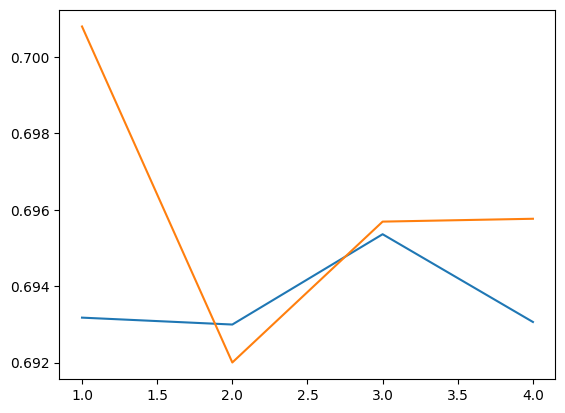

In [90]:
history.history['val_loss']

plt.plot([1,2,3,4], history.history['val_loss'])
plt.plot([1,2,3,4], history.history['loss'])

# Test prediction

In [39]:
file_path = os.path.join('train_embeddings_batches', 'batch_0.pkl')
with open(file_path, 'rb') as f:
    batch_data = pickle.load(f)  # list of padded arrays for batch

batch_data = np.array(batch_data)  # convert list to array, shape: (batch_sentences, maxlen, vec_size)

# Extract corresponding labels for this batch
batch_size_sentences = batch_data.shape[0]

text_pred = batch_data[0,:,:].reshape((1,400,50))
text_pred.shape

(1, 400, 50)

In [40]:
model.predict(text_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


array([[0.48299447]], dtype=float32)

# Save model

# Remove intermediate files directories

In [1]:
!rm -r train_embeddings_batches/ val_embeddings_batches/